In [147]:
import argparse
import glob
import os
from tqdm import tqdm
import cv2
import imageio
import numpy as np
import skimage.morphology
import torch
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)


def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)[..., :3]
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)


def get_uv_grid(H, W, homo=False, align_corners=False, device=None):
    """
    Get uv grid renormalized from -1 to 1
    :returns (H, W, 2) tensor
    """
    if device is None:
        device = torch.device("cpu")
    yy, xx = torch.meshgrid(
        torch.arange(H, dtype=torch.float32, device=device),
        torch.arange(W, dtype=torch.float32, device=device),
        indexing="ij",
    )
    if align_corners:
        xx = 2 * xx / (W - 1) - 1
        yy = 2 * yy / (H - 1) - 1
    else:
        xx = 2 * (xx + 0.5) / W - 1
        yy = 2 * (yy + 0.5) / H - 1
    if homo:
        return torch.stack([xx, yy, torch.ones_like(xx)], dim=-1)
    return torch.stack([xx, yy], dim=-1)


def compute_sampson_error(x1, x2, F):
    """
    :param x1 (*, N, 2)
    :param x2 (*, N, 2)
    :param F (*, 3, 3)
    """
    h1 = torch.cat([x1, torch.ones_like(x1[..., :1])], dim=-1)
    h2 = torch.cat([x2, torch.ones_like(x2[..., :1])], dim=-1)
    d1 = torch.matmul(h1, F.transpose(-1, -2))  # (B, N, 3)
    d2 = torch.matmul(h2, F)  # (B, N, 3)
    z = (h2 * d1).sum(dim=-1)  # (B, N)
    err = z**2 / (
        d1[..., 0] ** 2 + d1[..., 1] ** 2 + d2[..., 0] ** 2 + d2[..., 1] ** 2
    )
    return err


def run_maskrcnn(model, img_path):
    threshold = 0.5
    o_image = Image.open(img_path).convert("RGB")
    width, height = o_image.size
    if width > height:
        intHeight = 576
        intWidth = 1024
    else:
        intHeight = 1024
        intWidth = 576

    image = o_image.resize((intWidth, intHeight), Image.Resampling.LANCZOS)

    image_tensor = torchvision.transforms.functional.to_tensor(image).to(DEVICE)

    tenHumans = torch.FloatTensor(intHeight, intWidth).fill_(1.0).to(DEVICE)

    objPredictions = model([image_tensor])[0]

    for intMask in range(objPredictions["masks"].size(0)):
        if objPredictions["scores"][intMask].item() > threshold:
            # person, vehicle, accessory, animal, sports
            if objPredictions["labels"][intMask].item() == 1:  # person
                tenHumans[objPredictions["masks"][intMask, 0, :, :] > threshold] = 0.0
            if (
                objPredictions["labels"][intMask].item() >= 2
                and objPredictions["labels"][intMask].item() <= 9
            ):  # vehicle
                tenHumans[objPredictions["masks"][intMask, 0, :, :] > threshold] = 0.0
            if (
                objPredictions["labels"][intMask].item() >= 26
                and objPredictions["labels"][intMask].item() <= 33
            ):  # accessory
                tenHumans[objPredictions["masks"][intMask, 0, :, :] > threshold] = 0.0
            if (
                objPredictions["labels"][intMask].item() >= 16
                and objPredictions["labels"][intMask].item() <= 25
            ):  # animal
                tenHumans[objPredictions["masks"][intMask, 0, :, :] > threshold] = 0.0
            if (
                objPredictions["labels"][intMask].item() >= 34
                and objPredictions["labels"][intMask].item() <= 43
            ):  # sports
                tenHumans[objPredictions["masks"][intMask, 0, :, :] > threshold] = 0.0
            if objPredictions["labels"][intMask].item() == 88:  # teddy bear
                tenHumans[objPredictions["masks"][intMask, 0, :, :] > threshold] = 0.0

    npyMask = skimage.morphology.erosion(
        tenHumans.cpu().numpy(), skimage.morphology.disk(1)
    )
    npyMask = ((npyMask < 1e-3) * 255.0).clip(0.0, 255.0).astype(np.uint8)
    return npyMask


def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow_new = flow.copy()
    flow_new[:, :, 0] += np.arange(w)
    flow_new[:, :, 1] += np.arange(h)[:, np.newaxis]

    res = cv2.remap(
        img, flow_new, None, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT
    )
    return res


def get_stats(X, norm=2):
    """
    :param X (N, C, H, W)
    :returns mean (1, C, 1, 1), scale (1)
    """
    mean = X.mean(dim=(0, 2, 3), keepdim=True)  # (1, C, 1, 1)
    if norm == 1:
        mag = torch.abs(X - mean).sum(dim=1)  # (N, H, W)
    else:
        mag = np.sqrt(2) * torch.sqrt(torch.square(X - mean).sum(dim=1))  # (N, H, W)
    scale = mag.mean() + 1e-6
    return mean, scale


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--dataset_path", type=str, help="Dataset path", default='data')
    args = parser.parse_args([])
    data_dir = args.dataset_path
    netMaskrcnn = (
        torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
        .to(DEVICE)
        .eval()
    )


    scores = {} # scores is an empty dict already

    

    for seq in ['basketball']:
      for k in range(5, 6):
        #images = sorted(glob.glob(os.path.join(data_dir, "images", "*.jpg")))
        images = sorted(glob.glob(os.path.join(data_dir, f"{seq}/ims/{k}", "*.jpg")))

        img = load_image(images[0])
        H = img.shape[2]
        W = img.shape[3]

        # RUN SEMANTIC SEGMENTATION
        #img_path_list = sorted(glob.glob(os.path.join(data_dir, "images", "*.jpg")))
        img_path_list = sorted(glob.glob(os.path.join(data_dir, f"{seq}/ims/{k}", "*.jpg")))

        mask_rcnn_masks = []
        for i in range(0, len(img_path_list)):
            img_path = img_path_list[i]
            img_name = img_path.split("/")[-1]
            semantic_mask = run_maskrcnn(netMaskrcnn, img_path)
            semantic_mask = cv2.resize(
                semantic_mask, (W, H), interpolation=cv2.INTER_NEAREST
            )
            mask_rcnn_masks.append(semantic_mask)

        uv = get_uv_grid(H, W, align_corners=False)
        x1 = uv.reshape(-1, 2)
        motion_mask_frames = []
        motion_mask_frames2 = []
        flow_for_bilateral = []
        for idx, _ in tqdm(enumerate(images), total=len(images)):
            motion_masks = []
            weights = []
            err_list = []
            normalized_flow = []
            this_flow = 0
            counter = 0
            for step in [1]:
                if idx - step >= 0:
                    # backward flow and mask
                    
                    bwd_flow_path = os.path.join(
                        data_dir, f"{seq}/flow/{k}", str(idx).zfill(5) + "_bwd.npz"
                    )
                    bwd_data = np.load(bwd_flow_path)
                    bwd_flow, bwd_mask = bwd_data["flow"], bwd_data["mask"]
                    this_flow = np.copy(this_flow - bwd_flow)
                    counter += 1
                    bwd_flow = torch.from_numpy(bwd_flow)
                    bwd_mask = np.float32(bwd_mask)
                    bwd_mask = torch.from_numpy(bwd_mask)
                    flow = torch.from_numpy(
                        np.stack(
                            [
                                2.0 * bwd_flow[..., 0] / (W - 1),
                                2.0 * bwd_flow[..., 1] / (H - 1),
                            ],
                            axis=-1,
                        )
                    )
                    normalized_flow.append(flow)
                    x2 = x1 + flow.view(-1, 2)  # (H*W, 2)
                    F, mask = cv2.findFundamentalMat(x1.numpy(), x2.numpy(), cv2.FM_LMEDS)
                    F = torch.from_numpy(F.astype(np.float32))  # (3, 3)
                    err = compute_sampson_error(x1, x2, F).reshape(H, W)
                    fac = (H + W) / 2
                    err = err * fac**2
                    err_list.append(err)
                    weights.append(bwd_mask.mean())

                if idx + step < len(images):
                    # forward flow and mask
                    fwd_flow_path = os.path.join(
                        data_dir, f"{seq}/flow/{k}", str(idx).zfill(5) + "_fwd.npz"
                    )
                    fwd_data = np.load(fwd_flow_path, allow_pickle=True)
                    fwd_flow, fwd_mask = fwd_data["flow"], fwd_data["mask"]
                    this_flow = np.copy(this_flow + fwd_flow)
                    counter += 1
                    fwd_flow = torch.from_numpy(fwd_flow)
                    fwd_mask = np.float32(fwd_mask)
                    fwd_mask = torch.from_numpy(fwd_mask)
                    flow = torch.from_numpy(
                        np.stack(
                            [
                                2.0 * fwd_flow[..., 0] / (W - 1),
                                2.0 * fwd_flow[..., 1] / (H - 1),
                            ],
                            axis=-1,
                        )
                    )
                    normalized_flow.append(flow)
                    x2 = x1 + flow.view(-1, 2)  # (H*W, 2)
                    F, mask = cv2.findFundamentalMat(x1.numpy(), x2.numpy(), cv2.FM_LMEDS)
                    F = torch.from_numpy(F.astype(np.float32))  # (3, 3)
                    err = compute_sampson_error(x1, x2, F).reshape(H, W)
                    fac = (H + W) / 2
                    err = err * fac**2
                    err_list.append(err)
                    weights.append(fwd_mask.mean())

            err = torch.amax(torch.stack(err_list, 0), 0)
            flow_for_bilateral.append(this_flow / counter)

            thresh = torch.quantile(err, 0.8)
            err = torch.where(err <= thresh, torch.zeros_like(err), err)

            mask = torch.from_numpy(skimage.morphology.binary_opening(
                    err.numpy() > (H * W / (300000.0)), skimage.morphology.disk(1)
                )
            )  # 64.0 for nvidia, 49.0 for DAVIS_480p, 256.0 for DAVIS_1080p
            # combine
            mask_rcnn_mask = torch.from_numpy(mask_rcnn_masks[idx])
            mask[mask_rcnn_mask > 1] = 1.0

            mask = torch.from_numpy(
                skimage.morphology.dilation(mask.cpu(), skimage.morphology.disk(2))
            ).float()
            print(mask.shape)
            """if not os.path.exists(os.path.join(data_dir, f"{seq}/epipolar_error_png/{k}")):
                os.makedirs(os.path.join(data_dir, f"{seq}/epipolar_error_png/{k}"))
            Image.fromarray(((mask).numpy() * 255.0).astype(np.uint8)).save(
                os.path.join(data_dir, f"{seq}/epipolar_error_png/{k}", str(idx).zfill(5) + ".png")
            )"""



  1%|          | 1/150 [00:03<08:39,  3.48s/it]


KeyboardInterrupt: 

In [116]:
skimage.morphology.binary_opening(
                    err.numpy() > (H * W / (300000.0)), skimage.morphology.disk(1)
)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [117]:
tmp.shape, mask_rcnn_masks[0].shape

(torch.Size([360, 640]), (360, 640))

TypeError: where() missing 1 required positional arguments: "other"

In [124]:
mask_rcnn_masks[0].max()

255

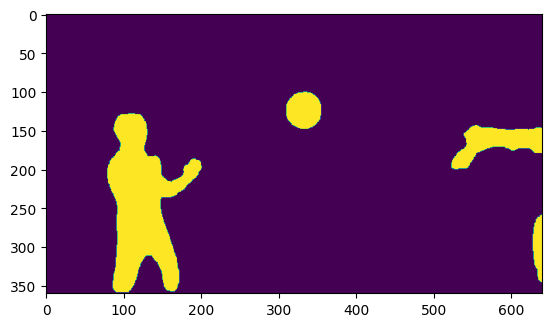

In [131]:
tmp[mask_rcnn_mask > 1] = 1.0
plt.imshow(tmp)

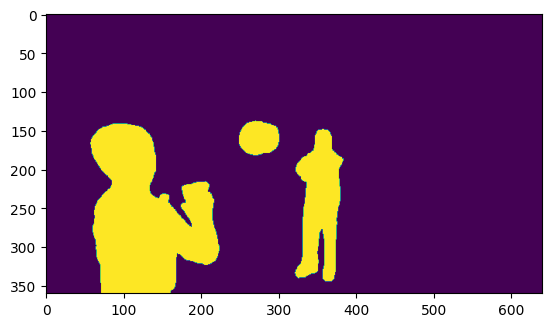

In [148]:
tmp = torch.from_numpy(skimage.morphology.binary_opening(
                    err.numpy() > (H * W / (300000.0)), skimage.morphology.disk(1)
                )
            )
tmp[mask_rcnn_mask > 1] = 1.0

plt.imshow(tmp)

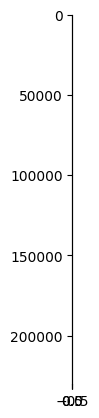

In [149]:
plt.imshow(mask)